In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""Script: make fxw plot of distribution from FW summaries.

Created on Sun May 23 2021

@author: yoav
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import concurrent.futures as cf
from itertools import product
import glob as glob

In [51]:
def dist_from_files(main_loc, frange, wrange, step_range,
                    dists, name):
    """Get dist from files."""
    ifrange = range(len(frange))
    iwrange = range(len(wrange))
    arg_generator = (
                     (step_range, 
                      main_loc+f'/f{frange[i[0]]}w{wrange[i[1]]}',
                      dists[i[0]][i[1]], name)
                     for i in product(ifrange, iwrange)
                    )
    with cf.ThreadPoolExecutor() as ex:
        ex.map(tuple_args_ij_files, arg_generator)

    #         all_cluster_dists[i][j][:] /= len(step_range)
    # for i in ifrange:
    #     for j in iwrange:
    #         dists[i][j][:] /= len(step_range)


def tuple_args_ij_files(arg_tuple):
    """Wrap single file."""
    dist_from_ij(*arg_tuple)


def dist_from_ij(step_range,
                 file_loc, data, name, 
                 from_end=True):
    """Get cluster distribution of a single fiwj folder."""
    #  start
    pystat_names = ("No", "Volume", "Area", "lambda1",
                    "lambda2", "lambda3", "Nbw/Nb", "hbar",
                    "mean_cluster_size", "std_cluster_size",
                    "line_length", "asphericity", "gyration_radius",
                    "acylindricity",
                   )
    stat_names = ("Epoch","OuterLoop", "VertexMoveSucessRate",
                  "BondFlipSuccessRate"
                 )
    
    if name in pystat_names:
        # get a main_statistics or pystatisics 
        # (regular statistics: output of trisurf)
        stat_csv = glob.glob(file_loc+'/[mp]*.csv')[0]
        df = pd.read_csv(stat_csv)
        
    elif name in stat_names:
        # get stuff that only exists in statistics.csv
        df = pd.read_csv(file_loc+'/statistics.csv')
    
    if from_end:
        last = pd.shape[0]-1 #rows
        use_step = lambda x: last-x
    else:
        use_step = lambda x: x
    
    # use options
    if name=='asphericity':
        for k, step in enumerate(step_range):
            data[k] = (df['lambda3'][use_step(step)]
                       -0.5*df['lambda2'][use_step(step)]
                       -0.5*df['lambda1'][use_step(step)])
    elif name=='gyration_radius':
        for k, step in enumerate(step_range):
            data[k] = (df['lambda1'][use_step(step)]
                       +df['lambda2'][use_step(step)]
                       +df['lambda3'][use_step(step)])
    elif name=='acylindricity':
        for k, step in enumerate(step_range):
            data[k] = (df['lambda2'][use_step(step)]
                       -df['lambda1'][use_step(step)])
    else:
        for k, step in enumerate(step_range):
            data[k] = df[name][use_step(step)]

In [52]:
#import glob as glob
#loc = glob.glob(r'/mnt/c/Users/yoavr/Desktop'
#          r'/paraview_pipeline/hello_chemfarm'
#          r'/13_from_various_stability/2_from_buds'
#          r'/f0w0'+'/[mp]*.csv')
#
#df = pd.read_csv(loc[0])
#df.shape[0]

In [53]:
def plot_fxw_hists(dists, frange, wrange, step_range,
                   mean_dist, var_dist, name, do_legend=True, do_title=True):
    """Plot fxw graphs.

    plot fxw graphs in a square, in a matrixlike form
    from a fxw list/tuple of numpy arrays dists[i][j]=array([...])
    """
    def dist_label_mean(x):
        return fr'$\mu = {x:.2f}$'

    def dist_label_var(x):
        return fr'$\sigma = {x:.2f}$'

    flen = len(frange)
    wlen = len(wrange)
    ifrange = range(flen)
    iwrange = range(wlen)

    # get the range of y
    max_y = np.zeros(wlen)
    min_y = np.zeros(wlen)

    # f is in the 2nd, horizontal axis
    # w is in the 1st, vertical axis
    for i in iwrange:
        for j in ifrange:
            # get maximum hieght
            max_y[i] = dists[j][i].max()
            min_y[i] = dists[j][i].min()

    # make big figure
    plt.rcParams['figure.figsize'] = [35, 18] # [10,6.8] # [20,18]
    # plt.rcParams['figure.dpi'] = 200
    fig, axes = plt.subplots(nrows=wlen, ncols=flen, num=name)

    # do axis things on the axis
    bottom_y = len(iwrange)-1
    left_x = 0

    for i, w in zip(reversed(iwrange), reversed(wrange)):
        for j, f in zip(ifrange, frange):
            axe = axes[i, j]

            axe.plot(step_range, dists[j][i],
                     color='red'), #linewidth=0.2)
            if do_legend:
                # custom legend
                axe.plot([], [], marker='.', color='red',
                         label=dist_label_mean(mean_dist[j][i]))
                axe.plot([], [], marker='.', color='red',
                         label=dist_label_var(np.sqrt(var_dist[j][i])))
            # plot parameters

            if i == bottom_y:
                5
                #axe.tick_params(direction='in')
            else:
                #axe.sharex(axes[bottom_y, j])
                axe.tick_params(direction='in', labelbottom=False)

            if j == left_x:
                #axe.set_ylim([min_y[i], 1.1*max_y[i]])
                axe.tick_params(direction='in')
            else:
                #axe.sharey(axes[i, left_x])
                axe.tick_params(direction='in', labelright=False)
            # axe.set_xlabel('cluster size')
            # axe.set_ylabel('number of clusters')
            if do_title:
                axe.set_title(f' f=0.{f+2}, w={1.75+0.25*w}: {name}')
            # axe.set_aspect('equal', 'box')
            # f=0.{f}, w={0.5+0.25*w} for FW_aggregate
            # f=0.{f+2}, w={1.75+0.25*w} for 13/from/various_stability
            # f={0.05*f}, w={1.25+1.5*w} for HIV_gag/4_lines
            if do_legend:
                axe.legend(numpoints=1, handlelength=0,
                           markerscale=0, handletextpad=0)

    plt.tight_layout()
    plt.show()

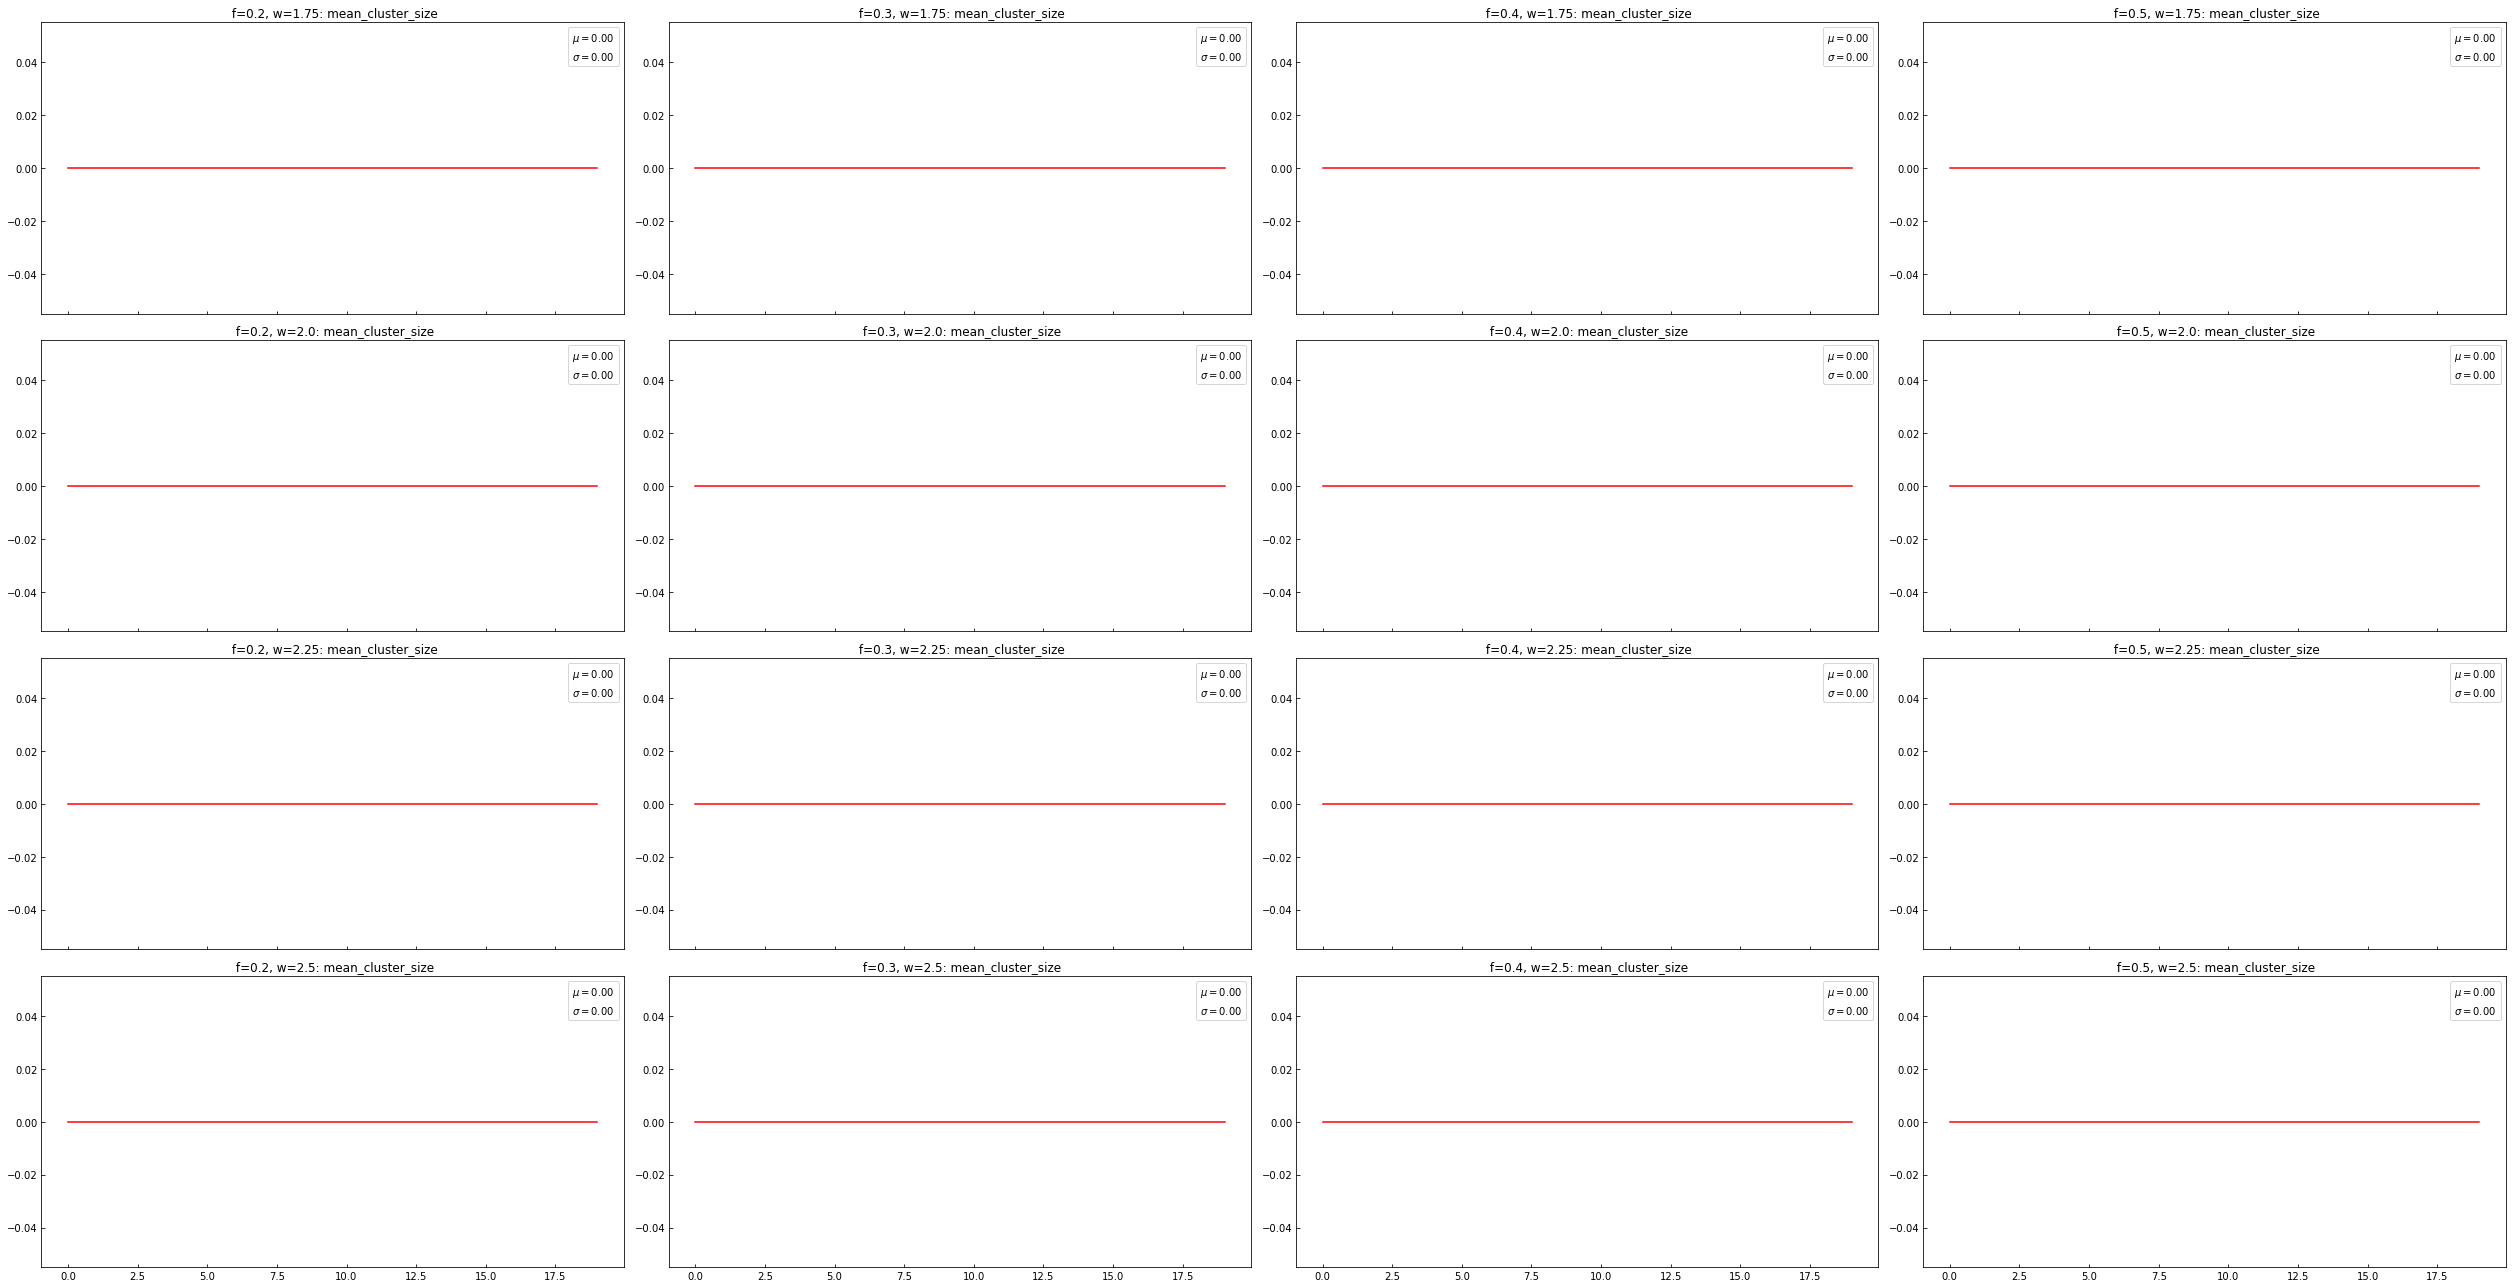

In [54]:

%matplotlib inline
"""Do main function.

does the thing
"""
main_loc = (r'/mnt/c/Users/yoavr/Desktop'
            r'/paraview_pipeline/hello_chemfarm'
            #r'/FW_block_aggregated/timesteps'
            #r'/HIV_gag/1_attempt_1'
            r'/13_from_various_stability/2_from_buds' # goes to 300, 4x4
            #r'/HIV_gag/2_attempt_2'
            #r'/HIV_gag/4_lines' # goes to 150
            #r'/HIV_gag/3_fixed' # 5x5
            )
name = "mean_cluster_size" # lamdba1,lambda2,lamdba3, Area, Volume, mean_cluster_size, asphericity, gyration_radius, acylindricity

frange = range(0, 4)  # range f [2,6|5,9]
wrange = range(0, 4)
ifrange = range(len(frange))  # index range
iwrange = range(len(wrange))

step_range = range(0, 20)

dists = tuple(tuple(np.zeros(len(step_range))
                    for x in iwrange)
                for y in ifrange)

dist_from_files(main_loc, frange, wrange, step_range,
                dists, name)

mean_dist = [[dists[i][j].mean()
                for j in iwrange]
                for i in ifrange]
var_dist = [[dists[i][j].var()
                for j in iwrange]
            for i in ifrange]

plot_fxw_hists(dists, frange, wrange, step_range,
               mean_dist, var_dist, name)


